In [84]:
import numpy as np
import pandas as pd

In [85]:
class FunkSVD:
    def __init__(self, n_factors=20, learning_rate=0.01, n_epochs=20, reg=0.02):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.reg = reg

    def fit(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        self.n_users, self.n_items = user_item_matrix.shape
        self.user_factors = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))

        for epoch in range(self.n_epochs):
            for i in range(self.n_users):
                for j in range(self.n_items):
                    if self.user_item_matrix[i, j] > 0:
                        self.gradient_descent(i, j)

    def gradient_descent(self, i, j):
        prediction = self.predict(i, j)
        error = self.user_item_matrix[i, j] - prediction

        self.user_factors[i, :] += self.learning_rate * (error * self.item_factors[j, :] - self.reg * self.user_factors[i, :])
        self.item_factors[j, :] += self.learning_rate * (error * self.user_factors[i, :] - self.reg * self.item_factors[j, :])

    def predict(self, i, j):
        return np.dot(self.user_factors[i, :], self.item_factors[j, :])

    def full_matrix(self):
        return np.dot(self.user_factors, self.item_factors.T)

## Load

In [86]:
train = pd.read_csv("../../data/train/user_item.csv")
train.head()

,profile_id,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
0,86becbd667a94db3a3dee0854470de7c,0,0,0,4,0,0,0,3,6,2
1,676ee3fbf66b46078484ecaa99bc8d1a,4,0,0,0,0,0,0,0,3,4
2,fada060561c24d4a984cc6eba6e2a63a,0,4,0,0,0,0,0,0,0,2
3,5cd3b3a0e5284df1adf8cca2f59ed28f,0,4,12,0,0,0,0,3,0,0
4,8a6a2df8be214007991afb612eb64c1c,0,0,0,0,0,3,3,0,0,0


In [87]:
test = pd.read_csv("../../data/test/user_item.csv")
test.head()

,profile_id,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
0,b19c8e7ac2ff40ae92b4fcf3247f8912,0,4,4,0,3,0,0,0,0,0
1,0b680efe1a0a40788ebb6fb2c587b4a7,0,0,0,0,3,0,0,3,0,0
2,9232bc9e68744227bdcc537e44d159f7,0,4,0,4,0,0,0,3,3,2
3,6e7d42fc10ee466c80a4056b3ec0b072,0,4,0,4,0,3,0,3,0,0
4,72257b80d8c1407ead2b3af3e7891c25,0,4,0,4,0,0,3,3,3,0


## Transform

In [88]:
# Create user-item matrix from the offer columns
user_item_matrix = train.set_index("profile_id")

# Normalize the matrix using min-max scaling to bring values between 0 and 1
user_item_matrix_normalized = (user_item_matrix - user_item_matrix.min()) / (user_item_matrix.max() - user_item_matrix.min())

# Fill NaN values with 0 as FunkSVD expects a dense matrix
user_item_matrix_normalized = user_item_matrix_normalized.fillna(0)

user_item_matrix_normalized.head()

,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
profile_id,,,,,,,,,,
86becbd667a94db3a3dee0854470de7c,0.00,0.0,0.00,0.2,0.0,0.0,0.00,0.25,0.50,0.333333
676ee3fbf66b46078484ecaa99bc8d1a,0.25,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,0.666667
fada060561c24d4a984cc6eba6e2a63a,0.00,0.2,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.333333
5cd3b3a0e5284df1adf8cca2f59ed28f,0.00,0.2,0.75,0.0,0.0,0.0,0.00,0.25,0.00,0.000000
8a6a2df8be214007991afb612eb64c1c,0.00,0.0,0.00,0.0,0.0,0.2,0.25,0.00,0.00,0.000000


## Train

In [89]:
# Assuming user_item_matrix is already created and normalized
svd = FunkSVD(n_factors=4, learning_rate=0.01, n_epochs=20, reg=0.02)
svd.fit(user_item_matrix_normalized.values)

## Predict

In [90]:
# Get the predicted full matrix
predicted_matrix = svd.full_matrix()
predicted = pd.DataFrame(predicted_matrix)
predicted.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.009162,-0.004277,-0.020884,-0.005113,-0.006989,-0.010135,-0.010323,-0.004002,-0.004007,-0.015816
1,0.003142,-0.000373,0.005853,-0.002090,-0.001522,-0.001479,-0.005151,-0.005536,-0.009362,0.001438
2,0.010944,0.014779,0.018862,0.024832,0.016072,0.017234,0.032516,0.035932,0.032792,0.052681
3,-0.015866,-0.006664,-0.020795,-0.019702,-0.007448,-0.005839,-0.008864,-0.016559,-0.012713,-0.056685
4,0.015251,0.011843,0.026105,0.020618,0.012746,0.013844,0.021922,0.024306,0.018801,0.052616


## Test

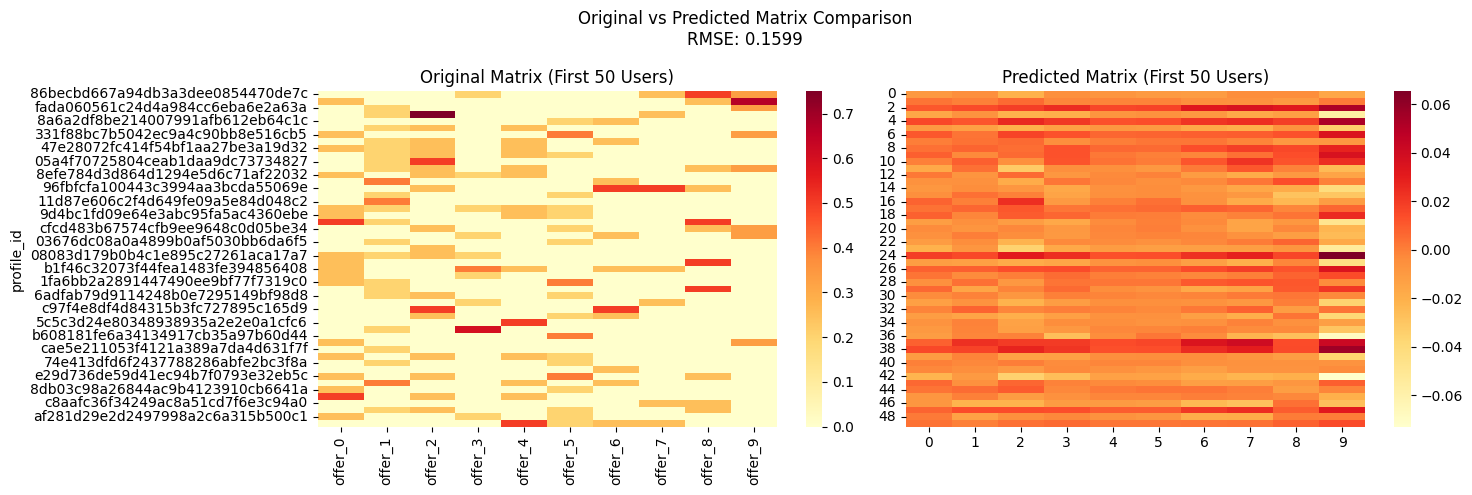

In [91]:
from sklearn.metrics import mean_squared_error
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(user_item_matrix_normalized.values.flatten(), 
                                predicted_matrix.flatten()))

# Create a comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot original matrix
sns.heatmap(user_item_matrix_normalized.iloc[:50, :], ax=ax1, cmap='YlOrRd')
ax1.set_title('Original Matrix (First 50 Users)')

# Plot predicted matrix
sns.heatmap(predicted_matrix[:50, :], ax=ax2, cmap='YlOrRd')
ax2.set_title('Predicted Matrix (First 50 Users)')

plt.suptitle(f'Original vs Predicted Matrix Comparison\nRMSE: {rmse:.4f}')
plt.tight_layout()
plt.show()

In [94]:
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error
import numpy as np

# Convert predictions to binary (1 if value > threshold, 0 otherwise)
threshold = 0.5
y_true = (user_item_matrix_normalized.values > threshold).astype(int)
y_pred = (predicted_matrix > threshold).astype(int)

# Calculate classical metrics
precision = precision_score(y_true.flatten(), y_pred.flatten())
recall = recall_score(y_true.flatten(), y_pred.flatten()) 
f1 = f1_score(y_true.flatten(), y_pred.flatten())

# Calculate error metrics
mae = mean_absolute_error(user_item_matrix_normalized.values.flatten(), predicted_matrix.flatten())
rmse = np.sqrt(mean_squared_error(user_item_matrix_normalized.values.flatten(), predicted_matrix.flatten()))

# Function to calculate MAP
def mean_average_precision(y_true, y_pred, k=10):
    ap_scores = []
    for i in range(len(y_true)):
        true_items = np.where(y_true[i] > threshold)[0]
        pred_items = np.argsort(y_pred[i])[::-1][:k]
        if len(true_items) > 0:
            ap = 0
            hits = 0
            for j, item in enumerate(pred_items):
                if item in true_items:
                    hits += 1
                    ap += hits / (j + 1)
            ap_scores.append(ap / min(len(true_items), k))
    return np.mean(ap_scores)

# Function to calculate NDCG
def ndcg(y_true, y_pred, k=10):
    ndcg_scores = []
    for i in range(len(y_true)):
        idcg = dcg(np.sort(y_true[i])[::-1][:k])
        if idcg > 0:
            ndcg_scores.append(dcg(y_pred[i][np.argsort(y_true[i])[::-1][:k]]) / idcg)
    return np.mean(ndcg_scores)

def dcg(scores):
    return np.sum(scores / np.log2(np.arange(2, len(scores) + 2)))

# Calculate ranking metrics
map_score = mean_average_precision(user_item_matrix_normalized.values, predicted_matrix)
ndcg_score = ndcg(user_item_matrix_normalized.values, predicted_matrix)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAP@10: {map_score:.4f}")
print(f"NDCG@10: {ndcg_score:.4f}")

/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
MAE: 0.0889
RMSE: 0.1599
MAP@10: 0.3306
NDCG@10: 0.0032


## Save

In [92]:
# Add profile_id back to the predicted DataFrame
predicted.index = user_item_matrix.index
predicted.columns = user_item_matrix.columns
predicted = predicted.reset_index()
predicted.head()

,profile_id,offer_0,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9
0,86becbd667a94db3a3dee0854470de7c,-0.009162,-0.004277,-0.020884,-0.005113,-0.006989,-0.010135,-0.010323,-0.004002,-0.004007,-0.015816
1,676ee3fbf66b46078484ecaa99bc8d1a,0.003142,-0.000373,0.005853,-0.002090,-0.001522,-0.001479,-0.005151,-0.005536,-0.009362,0.001438
2,fada060561c24d4a984cc6eba6e2a63a,0.010944,0.014779,0.018862,0.024832,0.016072,0.017234,0.032516,0.035932,0.032792,0.052681
3,5cd3b3a0e5284df1adf8cca2f59ed28f,-0.015866,-0.006664,-0.020795,-0.019702,-0.007448,-0.005839,-0.008864,-0.016559,-0.012713,-0.056685
4,8a6a2df8be214007991afb612eb64c1c,0.015251,0.011843,0.026105,0.020618,0.012746,0.013844,0.021922,0.024306,0.018801,0.052616


In [93]:
predicted.to_csv("../../data/predictions/matrix_factorization.csv", index=False)